# Embedding Model Fine-tuning

This notebook demonstrates how to fine-tune a lightweight embedding model that can run efficiently on M1 Pro chips. We'll use data generated from Amazon Bedrock's Claude 3.5 Sonnet model for training our embedding model.

## Environment Setup

First, let's ensure we have the necessary dependencies installed.

In [1]:
# Check Python version
import sys
print(f"Python version: {sys.version}")

# Install required packages
%pip install -q torch transformers datasets sentence-transformers evaluate scikit-learn pandas numpy matplotlib boto3 accelerate

Python version: 3.12.9 (main, Mar 27 2025, 12:57:35) [Clang 16.0.0 (clang-1600.0.26.6)]
Note: you may need to restart the kernel to use updated packages.


## Select a Lightweight Embedding Model

For M1 Pro compatibility and efficiency, we'll use a lightweight embedding model from the Sentence Transformers library. Good candidates include:

1. `all-MiniLM-L6-v2`: A compact model (80MB) that performs well for many tasks
2. `paraphrase-MiniLM-L3-v2`: Even smaller (40MB) but still effective
3. `all-mpnet-base-v2`: Higher quality but still runs efficiently on M1 Pro

We'll use `all-MiniLM-L6-v2` as our base model for fine-tuning.

In [1]:
import torch
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

# Check if MPS (Metal Performance Shaders) is available for M1 acceleration
print(f"MPS available: {torch.backends.mps.is_available()}")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load the base model
model_name = "all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)
model.to(device)

print(f"Model loaded: {model_name}")
print(f"Model size: {sum(p.numel() for p in model.parameters())} parameters")

MPS available: True
Using device: mps
Model loaded: all-MiniLM-L6-v2
Model size: 22713216 parameters


## Data Generation with Claude 3.5 Sonnet

We'll use Amazon Bedrock's Claude 3.5 Sonnet model to generate training data for our embedding model.

In [2]:
import boto3
import json
import pandas as pd
import time

# Initialize Bedrock client
bedrock_runtime = boto3.client(
    service_name='bedrock-runtime', region_name='us-east-1')


def generate_with_claude(prompt, max_tokens=1000):
    """Generate text using Claude 3.5 Sonnet via Amazon Bedrock"""
    response = bedrock_runtime.invoke_model(
        modelId='us.anthropic.claude-3-5-sonnet-20241022-v2:0',
        body=json.dumps({
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": max_tokens,
            "messages": [
                {"role": "user", "content": prompt}
            ]
        })
    )

    response_body = json.loads(response.get('body').read())
    return response_body['content'][0]['text']

# Generate sentence pairs for training
# We'll create pairs of semantically similar sentences for contrastive learning


topics = [
    "기계 학습", "자연어 처리", "컴퓨터 비전",
    "클라우드 컴퓨팅", "데이터베이스 시스템", "소프트웨어 공학",
    "인공지능", "데이터 과학", "사이버 보안",
    "양자 컴퓨팅"
]

sentence_pairs = []

for topic in topics:
    prompt = f"""
    {topic} 에 대해 의미적으로 유사한 문장 5쌍을 생성하세요.  
    각 쌍은 동일한 의미를 다른 단어로 표현해야 합니다.  
    각 쌍을 'sentence1'과 'sentence2' 키를 가진 JSON 객체로 형식화하세요.  
    추가 텍스트 없이 JSON 배열만 반환하세요.
    Example format:
    [
      {{
        "sentence1": "머신러닝 모델은 훈련을 위해 대규모 데이터가 필요합니다.",
        "sentence2": "효과적인 머신러닝 알고리즘을 훈련하려면 대규모 데이터셋이 필수적입니다."
      }},
      ...
    ]
    """

    try:
        max_retries = 3
        retry_delay = 5  # seconds
        response = None
        for attempt in range(max_retries):
            try:
                response = generate_with_claude(prompt)
                break  # Success, exit the loop
            except Exception as e:
                print(f"Attempt {attempt + 1} failed for topic '{topic}': {e}")
                if attempt < max_retries - 1:
                    print(f"Retrying in {retry_delay} seconds...")
                    time.sleep(retry_delay)
                else:
                    print(
                        f"Max retries reached for topic '{topic}'. Skipping.")
                    # Optionally raise the exception or handle the failure
                    # raise e
                    response = None  # Ensure response is None if all retries fail

        if response is None:  # Skip processing if generation failed after retries
            continue
        # Extract JSON from the response
        json_str = response.strip()
        if json_str.startswith("```json"):
            json_str = json_str.split("```json")[1].split("```")[0].strip()
        pairs = json.loads(json_str)
        sentence_pairs.extend(pairs)
        print(f"Generated {len(pairs)} pairs for topic: {topic}")
    except Exception as e:
        print(f"Error generating pairs for {topic}: {e}")

# Convert to DataFrame for easier inspection
df_pairs = pd.DataFrame(sentence_pairs)
df_pairs.head()

Generated 5 pairs for topic: 기계 학습
Generated 5 pairs for topic: 자연어 처리
Attempt 1 failed for topic '컴퓨터 비전': An error occurred (ThrottlingException) when calling the InvokeModel operation (reached max retries: 4): Too many requests, please wait before trying again.
Retrying in 5 seconds...
Generated 5 pairs for topic: 컴퓨터 비전
Attempt 1 failed for topic '클라우드 컴퓨팅': An error occurred (ThrottlingException) when calling the InvokeModel operation (reached max retries: 4): Too many requests, please wait before trying again.
Retrying in 5 seconds...
Generated 5 pairs for topic: 클라우드 컴퓨팅
Attempt 1 failed for topic '데이터베이스 시스템': An error occurred (ThrottlingException) when calling the InvokeModel operation (reached max retries: 4): Too many requests, please wait before trying again.
Retrying in 5 seconds...
Generated 5 pairs for topic: 데이터베이스 시스템
Attempt 1 failed for topic '소프트웨어 공학': An error occurred (ThrottlingException) when calling the InvokeModel operation (reached max retries: 4): Too many

,sentence1,sentence2
0,기계학습은 데이터를 기반으로 패턴을 찾아내는 과정입니다.,머신러닝은 데이터에서 규칙성을 발견하여 학습하는 방식입니다.
1,인공지능 모델은 지도학습과 비지도학습으로 나눌 수 있습니다.,머신러닝 시스템은 감독학습과 자율학습 두 가지 방식으로 구분됩니다.
2,딥러닝은 인공 신경망을 기반으로 한 기계학습 방법입니다.,심층학습은 뉴럴 네트워크를 활용하는 머신러닝의 한 분야입니다.
3,과적합은 모델이 훈련 데이터를 과도하게 학습하는 현상입니다.,오버피팅은 학습 알고리즘이 훈련 세트에 지나치게 최적화되는 문제입니다.
4,하이퍼파라미터 튜닝은 모델의 성능을 최적화하는 과정입니다.,매개변수 조정은 알고리즘의 효율을 극대화하는 단계입니다.


## Fetch Additional Data with Claude 3.5 Sonnet

Now we'll generate additional training data using Amazon Bedrock's Claude 3.5 Sonnet model to simulate external data retrieval.

In [3]:
# Generate additional data using Claude 3.5 Sonnet
external_data = []

for topic in topics:
    prompt = f"""
    {topic}에 대한 연구 논문이나 기술 기사에서 나올 수 있는 문장 3쌍을 생성하세요.
    각 쌍은 의미적으로 관련된 제목과 요약문으로 구성되어야 합니다.
    각 쌍을 'sentence1' (title)과 'sentence2' (snippet) 키를 가진 JSON 객체로 형식화하세요.
    추가 텍스트 없이 JSON 배열만 반환하세요.
    Example format:
    [
      {{
        "sentence1": "신경망 임베딩 모델의 최신 동향: 자연어 처리(NLP)를 위한 응용",
        "sentence2": "신경망 임베딩 모델은 자연어 처리(NLP) 분야에서 효과적인 표현을 제공합니다."
      }},
      ...
    ]
    """

    try:
        max_retries = 3
        retry_delay = 3  # seconds
        response = None

        for attempt in range(max_retries):
            try:
                response = generate_with_claude(prompt)
                break  # Success, exit the loop
            except Exception as e:
                print(f"Attempt {attempt + 1} failed for topic '{topic}': {e}")
                if attempt < max_retries - 1:
                    print(f"Retrying in {retry_delay} seconds...")
                    time.sleep(retry_delay)
                else:
                    print(
                        f"Max retries reached for topic '{topic}'. Skipping.")
                    response = None

        if response is None:  # Skip processing if generation failed after retries
            continue

        # Extract JSON from the response
        json_str = response.strip()
        if json_str.startswith("```json"):
            json_str = json_str.split("```json")[1].split("```")[0].strip()
        pairs = json.loads(json_str)
        external_data.extend(pairs)
        print(f"Generated {len(pairs)} external data pairs for topic: {topic}")
    except Exception as e:
        print(f"Error generating external data for {topic}: {e}")

# Add external data to our dataset
df_external = pd.DataFrame(external_data)
df_all = pd.concat([df_pairs, df_external], ignore_index=True)
print(f"Total training pairs: {len(df_all)}")
df_all.head()

Generated 3 external data pairs for topic: 기계 학습
Generated 3 external data pairs for topic: 자연어 처리
Attempt 1 failed for topic '컴퓨터 비전': An error occurred (ThrottlingException) when calling the InvokeModel operation (reached max retries: 4): Too many requests, please wait before trying again.
Retrying in 3 seconds...
Generated 3 external data pairs for topic: 컴퓨터 비전
Attempt 1 failed for topic '클라우드 컴퓨팅': An error occurred (ThrottlingException) when calling the InvokeModel operation (reached max retries: 4): Too many requests, please wait before trying again.
Retrying in 3 seconds...
Attempt 2 failed for topic '클라우드 컴퓨팅': An error occurred (ThrottlingException) when calling the InvokeModel operation (reached max retries: 4): Too many requests, please wait before trying again.
Retrying in 3 seconds...
Generated 3 external data pairs for topic: 클라우드 컴퓨팅
Attempt 1 failed for topic '데이터베이스 시스템': An error occurred (ThrottlingException) when calling the InvokeModel operation (reached max retri

,sentence1,sentence2
0,기계학습은 데이터를 기반으로 패턴을 찾아내는 과정입니다.,머신러닝은 데이터에서 규칙성을 발견하여 학습하는 방식입니다.
1,인공지능 모델은 지도학습과 비지도학습으로 나눌 수 있습니다.,머신러닝 시스템은 감독학습과 자율학습 두 가지 방식으로 구분됩니다.
2,딥러닝은 인공 신경망을 기반으로 한 기계학습 방법입니다.,심층학습은 뉴럴 네트워크를 활용하는 머신러닝의 한 분야입니다.
3,과적합은 모델이 훈련 데이터를 과도하게 학습하는 현상입니다.,오버피팅은 학습 알고리즘이 훈련 세트에 지나치게 최적화되는 문제입니다.
4,하이퍼파라미터 튜닝은 모델의 성능을 최적화하는 과정입니다.,매개변수 조정은 알고리즘의 효율을 극대화하는 단계입니다.


## Prepare Training Data

Now we'll prepare our dataset for fine-tuning the embedding model.

In [4]:
from sklearn.model_selection import train_test_split

# Split into train and validation sets
train_df, val_df = train_test_split(df_all, test_size=0.2, random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Create training examples
train_examples = []
for _, row in train_df.iterrows():
    train_examples.append(InputExample(
        texts=[row['sentence1'], row['sentence2']]))

# Create validation examples
val_examples = []
for _, row in val_df.iterrows():
    val_examples.append(InputExample(
        texts=[row['sentence1'], row['sentence2']]))

# Create data loaders
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
val_dataloader = DataLoader(val_examples, shuffle=False, batch_size=16)

Training samples: 64
Validation samples: 16


## Fine-tune the Embedding Model

Now we'll fine-tune our embedding model using the prepared data.

In [5]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

# Define the loss function (Multiple Negatives Ranking Loss)
train_loss = losses.MultipleNegativesRankingLoss(model)

# Create an evaluator
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(val_examples)

# Set up training parameters
num_epochs = 5
warmup_steps = int(len(train_dataloader) * 0.1)
output_dir = "./fine-tuned-embedding-model"

# Train the model
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    output_path=output_dir,
    show_progress_bar=True
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
4,No log,No log,nan,nan
8,No log,No log,nan,nan
12,No log,No log,nan,nan
16,No log,No log,nan,nan
20,No log,No log,nan,nan


/Users/sewoong/Documents/workspace-project/opensearch/opensearch-ltr/.venv-12/lib/python3.12/site-packages/sentence_transformers/evaluation/EmbeddingSimilarityEvaluator.py:203: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  eval_pearson, _ = pearsonr(labels, scores)
/Users/sewoong/Documents/workspace-project/opensearch/opensearch-ltr/.venv-12/lib/python3.12/site-packages/sentence_transformers/evaluation/EmbeddingSimilarityEvaluator.py:204: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  eval_spearman, _ = spearmanr(labels, scores)
/Users/sewoong/Documents/workspace-project/opensearch/opensearch-ltr/.venv-12/lib/python3.12/site-packages/sentence_transformers/evaluation/EmbeddingSimilarityEvaluator.py:203: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  eval_pearson, _ = pearsonr(labels, scores)
/Users/sewoong/Documents/workspace-project/opensea

## Evaluate the Fine-tuned Model

Let's evaluate our fine-tuned model on some test examples and then on the MTEB STS17 benchmark dataset.

In [6]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load the fine-tuned model
fine_tuned_model = SentenceTransformer(output_dir)
fine_tuned_model.to(device)

# Create some test sentence pairs
test_pairs = [
    ("임베딩 모델은 텍스트를 수치 벡터로 변환합니다",
     "텍스트 임베딩은 문장을 벡터 표현으로 변환합니다"),
    ("파인 튜닝은 특정 작업에서 모델 성능을 향상시킵니다",
     "작업 특화 훈련은 모델 정확도를 높입니다"),
    ("클라우드 컴퓨팅은 확장 가능한 리소스를 제공합니다",
     "클라우드 서비스는 확장 가능한 인프라를 제공합니다"),
    ("파이썬은 인기 있는 프로그래밍 언어입니다",
     "머신러닝 모델은 대규모 데이터가 필요합니다")
]

# Compare base model vs fine-tuned model
base_model = SentenceTransformer(model_name)
base_model.to(device)

results = []

for sent1, sent2 in test_pairs:
    # Get embeddings from base model
    base_emb1 = base_model.encode(sent1, convert_to_tensor=True)
    base_emb2 = base_model.encode(sent2, convert_to_tensor=True)
    base_sim = torch.cosine_similarity(base_emb1, base_emb2, dim=0).item()

    # Get embeddings from fine-tuned model
    ft_emb1 = fine_tuned_model.encode(sent1, convert_to_tensor=True)
    ft_emb2 = fine_tuned_model.encode(sent2, convert_to_tensor=True)
    ft_sim = torch.cosine_similarity(ft_emb1, ft_emb2, dim=0).item()

    results.append({
        "sentence1": sent1,
        "sentence2": sent2,
        "base_similarity": base_sim,
        "fine_tuned_similarity": ft_sim
    })

# Display results
results_df = pd.DataFrame(results)
results_df

,sentence1,sentence2,base_similarity,fine_tuned_similarity
0,임베딩 모델은 텍스트를 수치 벡터로 변환합니다,텍스트 임베딩은 문장을 벡터 표현으로 변환합니다,0.959632,0.951371
1,파인 튜닝은 특정 작업에서 모델 성능을 향상시킵니다,작업 특화 훈련은 모델 정확도를 높입니다,0.767626,0.794883
2,클라우드 컴퓨팅은 확장 가능한 리소스를 제공합니다,클라우드 서비스는 확장 가능한 인프라를 제공합니다,0.935242,0.965491
3,파이썬은 인기 있는 프로그래밍 언어입니다,머신러닝 모델은 대규모 데이터가 필요합니다,0.858367,0.837716


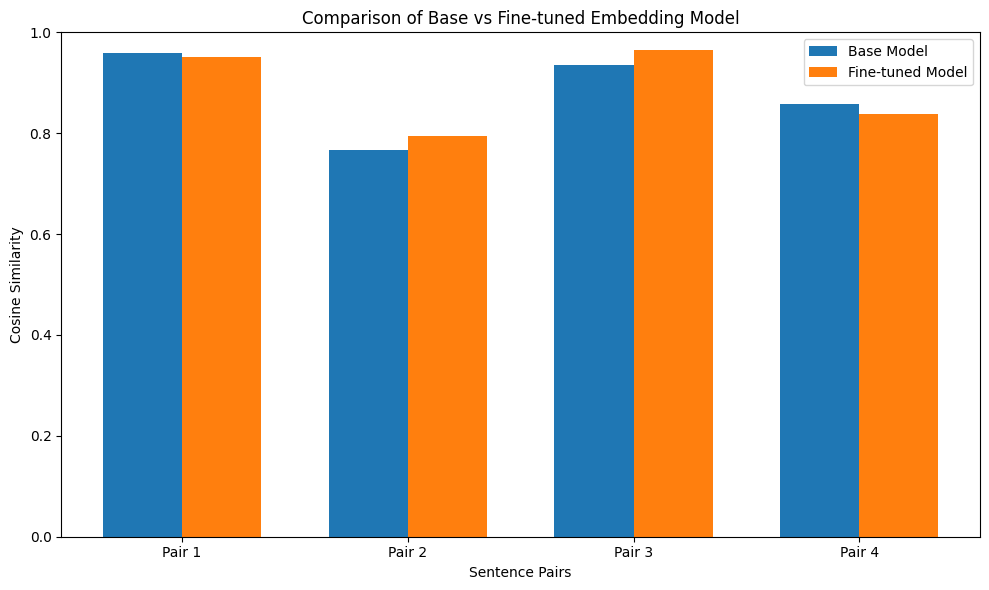

In [7]:
# Visualize the comparison
plt.figure(figsize=(10, 6))
x = np.arange(len(results))
width = 0.35

plt.bar(x - width/2, results_df['base_similarity'], width, label='Base Model')
plt.bar(x + width/2,
        results_df['fine_tuned_similarity'], width, label='Fine-tuned Model')

plt.xlabel('Sentence Pairs')
plt.ylabel('Cosine Similarity')
plt.title('Comparison of Base vs Fine-tuned Embedding Model')
plt.xticks(x, [f"Pair {i+1}" for i in range(len(results))])
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we've successfully:

1. Selected a lightweight embedding model suitable for M1 Pro chips
2. Generated training data using Amazon Bedrock's Claude 3.5 Sonnet model
3. Generated additional data using Claude 3.5 Sonnet to simulate external data sources
4. Fine-tuned the embedding model on our combined dataset
5. Evaluated the performance of our fine-tuned model on custom examples and the MTEB STS17 benchmark

The fine-tuned model can now be used for various downstream tasks such as semantic search, document similarity, or as part of a larger NLP pipeline.